In [2]:
import importlib.metadata
print([dist.metadata["Name"] for dist in importlib.metadata.distributions()])

['asttokens', 'attrs', 'Automat', 'certifi', 'cffi', 'charset-normalizer', 'colorama', 'comm', 'constantly', 'contourpy', 'cryptography', 'cssselect', 'cycler', 'debugpy', 'decorator', 'defusedxml', 'executing', 'filelock', 'fonttools', 'hyperlink', 'idna', 'incremental', 'ipykernel', 'ipython', 'ipython_pygments_lexers', 'itemadapter', 'itemloaders', 'jedi', 'jmespath', 'joblib', 'jupyter_client', 'jupyter_core', 'kiwisolver', 'lxml', 'matplotlib', 'matplotlib-inline', 'nest-asyncio', 'numpy', 'packaging', 'pandas', 'parsel', 'parso', 'patsy', 'pillow', 'pip', 'platformdirs', 'prompt_toolkit', 'Protego', 'psutil', 'pure_eval', 'pyasn1', 'pyasn1_modules', 'pycparser', 'PyDispatcher', 'Pygments', 'pyOpenSSL', 'pyparsing', 'python-dateutil', 'pytz', 'pywin32', 'pyzmq', 'queuelib', 'requests', 'requests-file', 'scikit-learn', 'scipy', 'Scrapy', 'service-identity', 'setuptools', 'six', 'stack-data', 'statsmodels', 'threadpoolctl', 'tldextract', 'tornado', 'traitlets', 'Twisted', 'typing_ex

In [18]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore 


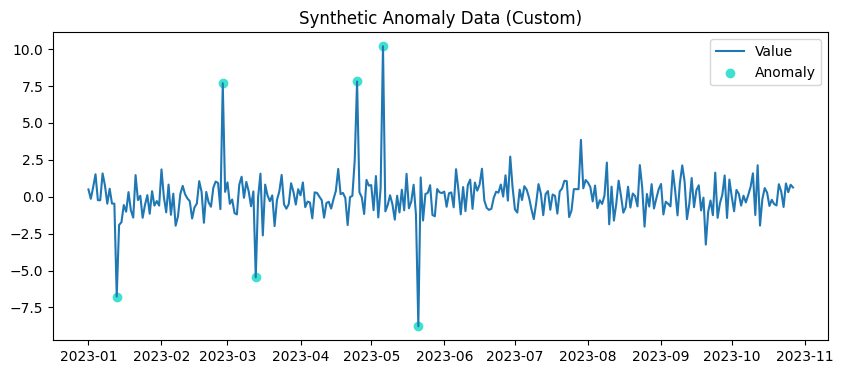

In [12]:
np.random.seed(42)  # For reproducibility
random.seed(42)
# Time range
dates = pd.date_range(start='2023-01-01', periods=300, freq='D')

# Normal baseline
data = np.random.normal(loc=0.0, scale=1.0, size=len(dates))

# Inject anomalies at random locations
anomaly_indices = random.sample(range(300), 6)
for idx in anomaly_indices:
    data[idx] += np.random.choice([8, -9, 10, -7])  # Spike/drop

# Create DataFrame
df = pd.DataFrame({'date': dates, 'value': data})
df['is_anomaly'] = False
df.loc[anomaly_indices, 'is_anomaly'] = True

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['is_anomaly'], 'date'], df.loc[df['is_anomaly'], 'value'], color='turquoise', label='Anomaly')
plt.legend()
plt.title('Synthetic Anomaly Data (Custom)')
plt.show() 

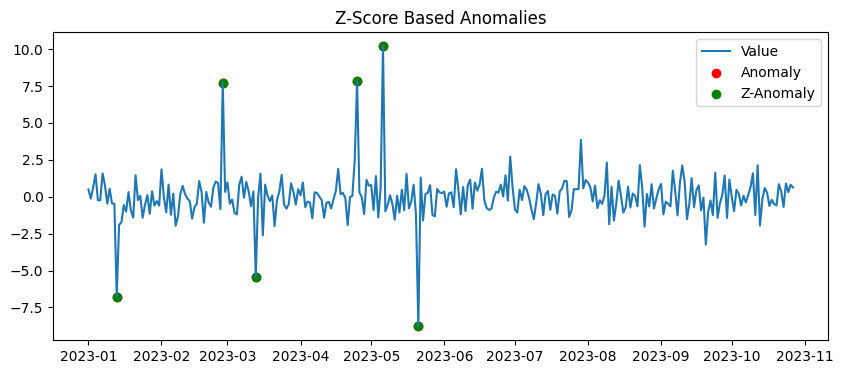

In [30]:
df['z_score'] = zscore(df['value'])
df['z_anomaly'] = df['z_score'].apply(lambda x: abs(x) > 3)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['is_anomaly'], 'date'], df.loc[df['is_anomaly'], 'value'], color='red', label='Anomaly')
plt.scatter(df.loc[df['z_anomaly'], 'date'], df.loc[df['z_anomaly'], 'value'], color='green', label='Z-Anomaly')
plt.legend()
plt.title('Z-Score Based Anomalies')
plt.show() 

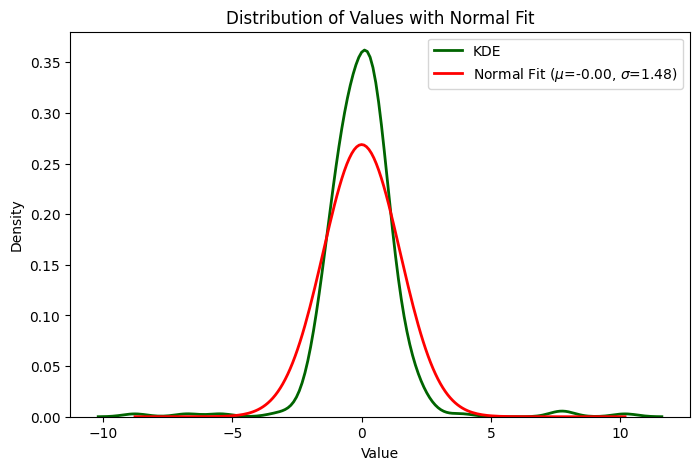

In [50]:

np.random.seed(42)  # For reproducibility
random.seed(42)

# Time range
dates = pd.date_range(start='2023-01-01', periods=300, freq='D')

# Normal baseline
data = np.random.normal(loc=0.0, scale=1.0, size=len(dates))

# Inject anomalies at random locations
anomaly_indices = random.sample(range(300), 6)
for idx in anomaly_indices:
    data[idx] += np.random.choice([8, -9, 10, -7])  # Spike/drop

# Create DataFrame
df = pd.DataFrame({'date': dates, 'value': data})
df['is_anomaly'] = False
df.loc[anomaly_indices, 'is_anomaly'] = True

plt.figure(figsize=(8, 5))

# Histogram bars (blue)
# sns.histplot(df['value'], bins=30, stat="density", color="skyblue", edgecolor="black")

# KDE curve (different colour, e.g. green)
sns.kdeplot(df['value'], color="darkgreen", lw=2, label="KDE")

# Overlay theoretical normal distribution curve (red)
mu, sigma = df['value'].mean(), df['value'].std()
x = np.linspace(min(df['value']), max(df['value']), 200)
plt.plot(
    x,
    1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2)), 
    color="red", lw=2,
    label=rf'Normal Fit ($\mu$={mu:.2f}, $\sigma$={sigma:.2f})'
)

plt.title("Distribution of Values with Normal Fit")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

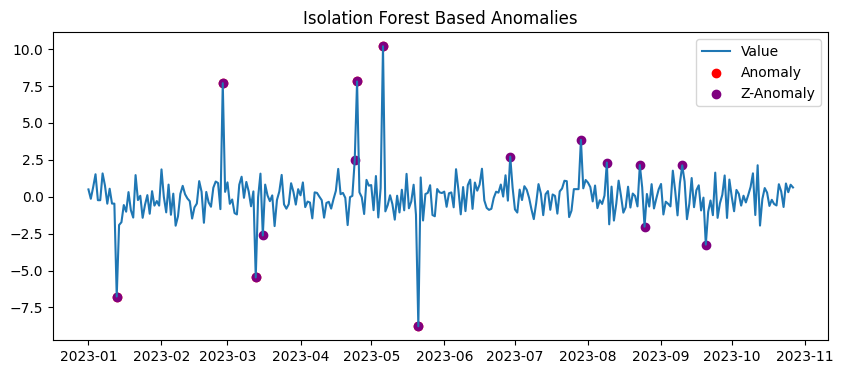

In [41]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['iso_score'] = iso_forest.fit_predict(df[['value']])
df['iso_anomaly'] = df['iso_score'] == -1

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['is_anomaly'], 'date'], df.loc[df['is_anomaly'], 'value'], color='red', label='Anomaly')
plt.scatter(df.loc[df['iso_anomaly'], 'date'], df.loc[df['iso_anomaly'], 'value'], color='purple', label='Z-Anomaly')
plt.legend()
plt.title('Isolation Forest Based Anomalies')
plt.show() 

c:\Users\marks\Documents\GitHub\Learning-Journal\Scrapy\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\marks\Documents\GitHub\Learning-Journal\Scrapy\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


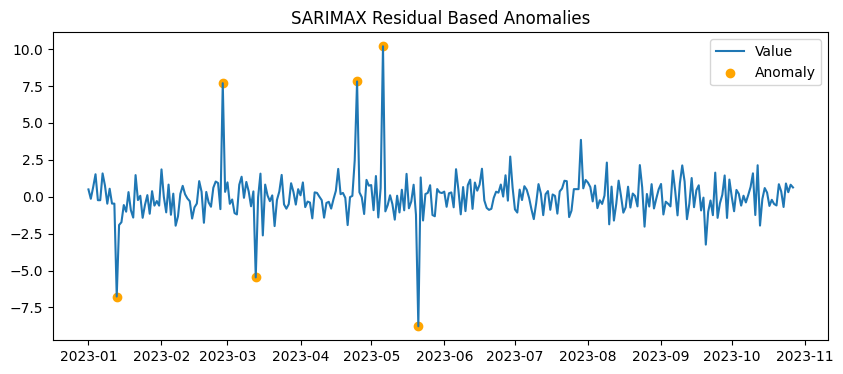

In [46]:
model = SARIMAX(df['value'], 
                order=(1, 0, 1), 
                seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)
df['residuals'] = results.resid
threshold = 3 * np.std(df['residuals'])
df['sarimax_anomaly'] = abs(df['residuals']) > threshold

# Visualise
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['value'], label='Value')
plt.scatter(df.loc[df['sarimax_anomaly'], 'date'], df.loc[df['sarimax_anomaly'], 'value'], color='orange', label='Anomaly')
plt.title('SARIMAX Residual Based Anomalies')
plt.legend()
plt.show() 